In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
data = pd.read_csv("./new-cases-per-week.csv", index_col=0)
data

,0.1
0,
1,0
2,0
3,0
4,0
5,2
...,...
90,795
91,551
92,632


# Part 1: Analyzing COVID data

## Analysis (4 points)

### 1. Cubic splines.

In [85]:
m = data.shape[0]
n = m - 1 # number of eqns
splines = np.zeros((n * 4, n * 4))
t_vec = np.array(data.index)

print(splines.shape)

# Fist we fill in the matrix with the terms of the cubic equation
# This is essentially a vandermonde matrix so
vander = np.vander(t_vec, N=4, increasing=True)
print(vander.shape)
offset = 0
# Now we require each endpoint of each spline to be equal to the point evaluated.
for i in range(0, n):
    # print(i*2 + 1, i*2 + 2)
    splines[i*2, offset : offset + 4] = vander[i]
    splines[i*2 + 1, offset : offset + 4] = vander[i + 1]
    offset += 4
# Fill to n*2 - 1

# We set the derivatites of the functions to be continuous
# There are n - 1 points where we can do this
start_of_first_deriv = n * 2
offset = 0
for i in range(1, n):
    splines[i - 1 + start_of_first_deriv, offset: offset + 8] = np.array([0, 1, 2*t_vec[i], 3*t_vec[i]**2, 0, -1, -2*t_vec[i], -3*t_vec[i]**2 ])
    offset += 4

# Now we just gotta fill it until the last two rows
start_of_second_deriv = start_of_first_deriv + n - 1
offset = 0
for i in range(1, n):
    splines[i - 1 + start_of_second_deriv, offset: offset + 8] = np.array([0, 0, 2, 6*t_vec[i], 0, 0, -2, -6*t_vec[i]])
    offset += 4

# Now we require the endpoints second derivative to be 0
splines[-2, :4] = np.array([0, 0, 2, 6*t_vec[0]])
splines[-1, -4:] = np.array([0, 0, 2, 6*t_vec[-1]])

# y = np.zeros((n*4,1))
# Zipping two vectors, flattening, remove 1st and last, reshape, gives us desired shape
y = np.stack((np.array(data), np.array(data)), axis = 1).flatten()[1:-1].reshape(n * 2, 1)
# We add a bunch of zero entries
y = np.append(y, np.zeros((n*2, 1)))
splines, y



(372, 372)
(94, 4)


(array([[ 1.00000e+00,  1.00000e+00,  1.00000e+00,  1.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
          0.00000e+00,  0

Now we can solve the system to get the coefficients

In [86]:
coefficients = np.linalg.solve(splines, y)
coefficients = coefficients.reshape(n, 4)
print(coefficients.shape)
coefficients

(93, 4)


array([[ 0.00000000e+00,  1.45245809e-01, -2.17868714e-01,
         7.26229045e-02],
       [ 3.48589942e+00, -5.08360332e+00,  2.39655585e+00,
        -3.63114523e-01],
       [-4.35737427e+01,  4.19760388e+01, -1.32899915e+01,
         1.37983519e+00],
       [ 2.46734187e+02, -1.75754909e+02,  4.11427454e+01,
        -3.15622622e+00],
       [-1.42842780e+03,  8.29342286e+02, -1.59876694e+02,
         1.02450697e+01],
       [ 1.82650261e+03, -7.98122923e+02,  1.11367508e+02,
        -4.82405260e+00],
       [-1.52806887e+04,  6.53353049e+03, -9.36011551e+02,
         4.50511407e+01],
       [ 4.63803165e+04, -1.65893465e+04,  1.95434807e+03,
        -7.53805102e+01],
       [-8.18636140e+03,  1.59954618e+03, -6.66400032e+01,
        -5.29100068e-01],
       [ 2.87876281e+04, -9.49265067e+03,  1.04257968e+03,
        -3.75030896e+01],
       [-2.49450665e+05,  6.63905202e+04, -5.85589040e+03,
         1.71541458e+02],
       [ 3.41878196e+05, -8.14416951e+04,  6.46346088e+03,
      

Here we have the coefficients for all 13 equations. Graph?

### 2. Graph & Integrate fit

We start by plotting this beautiful curve that took me five hours to make.

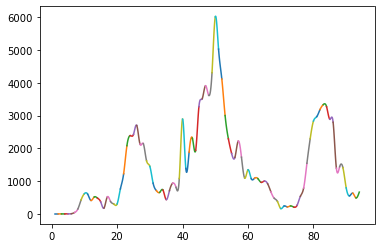

In [87]:
fig = plt.figure()
for i in range(data.index[0], data.index[-1]):
    x = np.linspace(i, i+1, 100)
    idx = i - data.index[0]
    fn = lambda x: coefficients[idx, 0] + coefficients[idx, 1] * x + coefficients[idx, 2] * (x**2) + coefficients[idx, 3] * (x**3)
    plt.plot(x, fn(x))
    

Now we can integrate the fit and find the error.

In [88]:
cum_sum = 0
for i in range(data.index[0], data.index[-1]):
    idx = i - data.index[0]
    # Cubic polynomials have a closed form integral function described below
    integral_fn = lambda x: coefficients[idx, 0] * x + 0.5 * coefficients[idx, 1] * (x**2) + 1/3 * coefficients[idx, 2] * (x**3) + 0.25* coefficients[idx, 3] * (x**4)
    # We can just evaluate F(b) - F(a)
    cum_sum += integral_fn(i + 1) - integral_fn(i)
error = data.sum() - cum_sum
error

0.1    356.081374
dtype: float64

The error is roughly 356 (pretty decent if you ask me).

### 3. Newton-Cotes

Now we will integrate the function using Simpson's Rule, a Newton-Cotes quadrature method. We use a step size of 1 to keep things simple(r).

In [89]:
cum_sum = 0
for i in range(data.index[0], data.index[-2]):
    fn = lambda x: int(data.iloc[x])
    cum_sum += 1/6*(fn(i) + 4*fn((i + i+1) // 2) + fn(i + 1))
error = data.sum() - cum_sum
error


0.1    554.166667
dtype: float64

The error here is roughly 554. The error between the methods is 198, which is a 1.4% relative error over the total sum. This indicates that the difference in using both methods is not significant. That being said, the spline case is more accurate. This makes sense because the spline interpolation is done with cubic polynomials, whereas Simpson's method uses a quadratic interpolating polynomial. Hence, given the same timestep it is reasonable to assume that the error will be higher when using Simpson's rule.

### 4. Computational cost

It is quite evident that the quadrature method is computatinally cheaper. It requires an $O(n)$ loop and 3 array accesses, with some basic operations. This is contrasted with taking intergrals over the spline: first you must fill the matrix which is $O(n)$, then you must solve it, and then run another loop to find the values of the closed integrals. 

## Uncertainty

First we add the noise. To do this we create a vector of the same size as the data with random values normally distributed around 1, then multiply them.

In [90]:
mu, sigma = 1, 0.1
noise = np.random.normal(mu, sigma, (m, 1))
noisy_data = abs(data * noise).astype(int)
noisy_data

,0.1
0,
1,0
2,0
3,0
4,0
5,2
...,...
90,813
91,600
92,688


Now we repeat steps 1-3

In [91]:
# Cubic Spline
m = noisy_data.shape[0]
n = m - 1 # number of eqns
splines = np.zeros((n * 4, n * 4))
t_vec = np.array(noisy_data.index)

print(splines.shape)

# Fist we fill in the matrix with the terms of the cubic equation
# This is essentially a vandermonde matrix so
vander = np.vander(t_vec, N=4, increasing=True)
print(vander.shape)
offset = 0
# Now we require each endpoint of each spline to be equal to the point evaluated.
for i in range(0, n):
    # print(i*2 + 1, i*2 + 2)
    splines[i*2, offset : offset + 4] = vander[i]
    splines[i*2 + 1, offset : offset + 4] = vander[i + 1]
    offset += 4
# Fill to idx 185

# We set t e derivatites of the functions to be continuous
# There are 92 points where we can do this
start_of_first_deriv = n * 2
offset = 0
for i in range(1, n):
    splines[i - 1 + start_of_first_deriv, offset: offset + 8] = np.array([0, 1, 2*t_vec[i], 3*t_vec[i]**2, 0, -1, -2*t_vec[i], -3*t_vec[i]**2 ])
    offset += 4

# print(splines[start_of_first_deriv + n - 2])
# Now we just gotta fill it until the last two rows
start_of_second_deriv = start_of_first_deriv + n - 1
offset = 0
for i in range(1, n):
    splines[i - 1 + start_of_second_deriv, offset: offset + 8] = np.array([0, 0, 2, 6*t_vec[i], 0, 0, -2, -6*t_vec[i]])
    offset += 4

# Now we require the endpoints second derivative to be 0
splines[-2, :4] = np.array([0, 0, 2, 6*t_vec[0]])
splines[-1, -4:] = np.array([0, 0, 2, 6*t_vec[-1]])

# y = np.zeros((n*4,1))
# Zipping two vectors, flattening, remove 1st and last, reshape, gives us desired shape
y = np.stack((np.array(data), np.array(data)), axis = 1).flatten()[1:-1].reshape(n * 2, 1)
y = np.append(y, np.zeros((n*2, 1)))

(372, 372)
(94, 4)


In [92]:
# Find coefficients
coefficients = np.linalg.solve(splines, y)
coefficients = coefficients.reshape(n, 4)
print(coefficients.shape)


(93, 4)


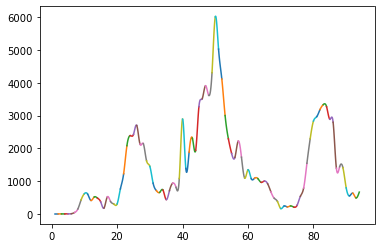

In [93]:
# Graph
fig = plt.figure()
for i in range(noisy_data.index[0], noisy_data.index[-1]):
    x = np.linspace(i, i+1, 100)
    idx = i - noisy_data.index[0]
    fn = lambda x: coefficients[idx, 0] + coefficients[idx, 1] * x + coefficients[idx, 2] * (x**2) + coefficients[idx, 3] * (x**3)
    plt.plot(x, fn(x))

In [94]:
# Integration
cum_sum = 0
for i in range(noisy_data.index[0], noisy_data.index[-1]):
    idx = i - noisy_data.index[0]
    # Cubic polynomials have a closed form integral function described below
    integral_fn = lambda x: coefficients[idx, 0] * x + 0.5 * coefficients[idx, 1] * (x**2) + 1/3 * coefficients[idx, 2] * (x**3) + 0.25* coefficients[idx, 3] * (x**4)
    # We can just evaluate F(b) - F(a)
    cum_sum += integral_fn(i + 1) - integral_fn(i)
error = abs(noisy_data.sum() - cum_sum)
error

0.1    3339.081374
dtype: float64

In [95]:
# Newton-Cotes
cum_sum = 0
for i in range(noisy_data.index[0], noisy_data.index[-2]):
    fn = lambda x: int(noisy_data.iloc[x])
    cum_sum += 1/6*(fn(i) + 4*fn((i + i+1) // 2) + fn(i + 1))
error = noisy_data.sum() - cum_sum
error

0.1    604.166667
dtype: float64

When the data is noisy we see better performance using the Newton-Cotes quadrature method. This is most likely because the polynomial fit is worse at performing with noise, as a polynomial is smooth. Hence, the deviations, peaks, and troughs intriduced by the noise cause it to perform worse. On the other hand, the quadrature method performs similarly, since it only interpolates between two points, meaning that it is more stable than integrating the spline. The conclusion does not change, it is usually more effecive to use a quadrature method rather than integrating a spline, if the intent is to find the area under a curve.

## Rounding

### 1. Converting to USG float (they really can't get anything right huh)

In effect what the rounding does is limit all numbers to having 2 non-zero leading digits (2 digit mantissa).

      0.1
0        
1     0.0
2     0.0
3     0.0
4     0.0
5     2.0
..    ...
90  800.0
91  550.0
92  630.0
93  490.0
94  660.0

[94 rows x 1 columns]


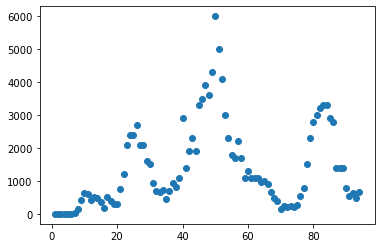

In [96]:
# This effect can be accomplished with the Python round() function, using log to calculate the number of figures in the number.
ndigits = 1
usg_data = data.applymap(lambda x: round(x, ndigits - int(np.floor(np.log10(abs(x))))) if x != 0 else 0.0)
print(usg_data)
plt.scatter(x=usg_data.index, y=usg_data)

The plot looks similar, as expected.

### 2. Summing using new float rules

In [97]:
# Special sum here so let's get fancy
ndigits = 1
cum_sum = 0
for n in usg_data["0.1"]:
    cum_sum = round(cum_sum + n, ndigits - int(np.floor(np.log10(abs(cum_sum + n))))) if cum_sum + n != 0.0 else 0.0
error = abs(data.sum() - cum_sum)
error

0.1    33443.0
dtype: float64

Error is as expected pretty significant.

# Part 2. Modeling the disease

### 1. Solving the system

In [98]:
def RK4SIR(n, beta, gamma, S0, I0, R0 = 0, dt = 1):
    # define initial values
    N = S0 + I0 + R0
    S = np.append(np.array([S0]), np.zeros((n, 1)))
    I = np.append(np.array([I0]), np.zeros((n, 1)))
    R = np.append(np.array([R0]), np.zeros((n, 1)))

    # define the functions
    dSdt = lambda t, S, I: -1 * beta * S * I / N
    dIdt = lambda t, S, I: beta * S * I / N - gamma * I
    dRdt = lambda t, I: gamma * I

    for i in range(n):
        Si = S[i]
        Ii = I[i]
        Ri = R[i]

        S_k1 = dSdt(i, Si, Ii)
        I_k1 = dIdt(i, Si, Ii)
        R_k1 = dRdt(i, Ii)

        S_k2 = dSdt(i + dt / 2, Si + dt / 2 * S_k1, Ii + dt / 2 * I_k1)
        I_k2 = dIdt(i + dt / 2, Si + dt / 2 * S_k1, Ii + dt / 2 * I_k1)
        R_k2 = dRdt(i + dt / 2, Ii + dt /2 * I_k2)

        S_k3 = dSdt(i + dt / 2, Si + dt / 2 * S_k2, Ii + dt / 2 * I_k2)
        I_k3 = dIdt(i + dt / 2, Si + dt / 2 * S_k2, Ii + dt / 2 * I_k2)
        R_k3 = dRdt(i + dt / 2, Ii + dt / 2 * I_k2)
        
        S_k4 = dSdt(i + dt, Si + dt * S_k3, Ii + dt * I_k3)
        I_k4 = dIdt(i + dt, Si + dt * S_k3, Ii + dt * I_k3)
        R_k4 = dRdt(i + dt, Ii + dt * I_k3)

        S[i + 1] = Si + dt / 6 * (S_k1 + 2 * S_k2 + 2 * S_k3 + S_k4)
        I[i + 1] = Ii + dt / 6 * (I_k1 + 2 * I_k2 + 2 * I_k3 + I_k4)
        R[i + 1] = N - S[i + 1] - I[i + 1]
    
    # Return in dataframe for fancy
    out = pd.DataFrame()
    out['S'] = S
    out['I'] = I
    out['R'] = R
    return out

Now we call the function with some initial values.

<AxesSubplot:>

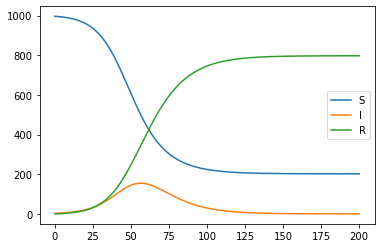

In [99]:
# Now we call it!
n = 200
beta = 0.2
gamma = 0.1
S0 = 997
I0 = 3
R0 = 0
dt = 1

data = RK4SIR(n, beta, gamma, S0, I0, R0, dt)
data.plot()

### 2. Get it looking like the COVID data

After playing around with the values for a while, I was not able to get the data to draw in the same way as the data provided at the beginning. This is most likely due to a some major reasons:

1. The SIR model does not take into account all the measures that were taken against COVID.
2. The SIR model does not account for stochastic events.
3. The SIR model is quite general, and cannot account for factors that seem to affect COVID-19 infections such as air pollution, social and cultural context, etc.
4. The SIR model assumes a closed population, which is an unfair assumption in today's day.
5. The SIR model assumes recovered individuals are not considered to be able to get infected again, this is false pertaining to COVID-19.